**Clustering Analysis**

  

**Objective**:

  

The major goal of this work is to acquire knowledge about clustering methods with an emphasis on the utilization of K-Means, Hierarchical, and DBSCAN algorithms. We are to complete a practical exercise where thesemethods are employed on EastWestAirlines data, a real-world dataset, to extract and describe differentcustomer segments. Such a hands-on approach will familiarize us with the functioning of these algorithmsin a commercial setting.



**Goal**:  Efficiency in clustering and extract meaningful insights from customer data.

**1. Datasets**:

We are working with the EastWestAirlines dataset, which contains detailed information about the passengers of East West Airlines, mainly focusing on their credit card usage, frequent flyer rewards, and general flying habits. The dataset has the following attributes:

**A) ID#**: the unique identification number of each customer.

**B) Balance**: The total miles eligible for award travel are shown in up to eight digits.

**C) Qual_miles**: The number of miles required to become Topflight.

**D) cc1_miles, cc2_miles, and cc3_miles**: The miles earned through different credit cards one is less than 5,000, two is between 5,000 and 10,000, three is between 10,001 and 25,000, four is between 25,001 and 50,000, and five is above 50,000.

**E) Bonus_miles, Bonus_trans**: The amount of non-flight bonus miles and transactions.

**F) Flight_miles_12mo, Flight_trans_12**: The flight miles and the number of flights during the last 12 months.

**G) Days_since_enroll**: The number of days since the client's enrollment.

**H) Award**: A binary indicator (1 = got an award, 0 = no award). Details: The dataset contains 4,021 records, and we have to group these customers into different segments based on the features given.

**2.                                 Data Preprocessing**



**A) Missing Values, Outliers, and Scaling**

Let's begin by using data to check for missing values. isnull(). Fortunately, there was no sum() in the dataset, so no imputation was necessary. Descriptive statistics were then used to find outliers; Balance's maximum value of 1,702,838 was significantly higher than the 99th percentile, which is roughly 605,757. We reduced skew by capping Balance at the 99th percentile in order to counteract this. We used standardization to guarantee equitable clustering because Balance, Days_since_enroll, and Bonus_miles have different scales. The dropna() function probably eliminated any problematic rows, as evidenced by the output's decreased row count of 3,999.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

#  Loading Excel file from correct sheet with correct header
data = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data', header=0)

#  Cleaning up column names (remove unwanted spaces)
data.columns = data.columns.str.strip()

#  Confirming column names
print("Column Names:\n", data.columns.tolist())

#  Checking for missing values
print("Missing Values:\n", data.isnull().sum())

#  Dropping rows with missing values in selected columns (safe practice)
required_cols = ['Balance', 'Days_since_enroll', 'Bonus_miles']
data.dropna(subset=required_cols, inplace=True)

#  Capped outliers at 99th percentile for Balance
data['Balance'] = data['Balance'].clip(upper=data['Balance'].quantile(0.99))

#  Scaling selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[required_cols])

#  Output shape to confirm
print("Shape of Scaled Data:", scaled_features.shape)

Column Names:
 ['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']
Missing Values:
 ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64
Shape of Scaled Data: (3999, 3)


Column Names: ['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?'] Missing Values: ID# 0 Balance 0 Qual_miles 0 cc1_miles 0 cc2_miles 0 cc3_miles 0 Bonus_miles 0 Bonus_trans 0 Flight_miles_12mo 0 Flight_trans_12 0 Days_since_enroll 0 Award? 0 dtype: int64 Shape of Scaled Data: (3999, 3)



column names now match the expected fields, confirming the header=0 fix. No missing values are present, and the scaled data shape (3,999 rows, 3 columns) aligns with the dataset size after dropping rows.

**B)               Exploratory Data Analysis (EDA)**



To investigate the dataset, we are utilizing data.describe(). A range of customer values is indicated by the average balance, which is roughly 70,949 miles, and the maximum, which is 459,757.26. With an average of 4,118.56 days and a maximum of 8,296 days, days_since_enroll indicates a lengthy customer tenure. About 37% of customers received awards, according to the mean of 0.37 displayed by Award? Potential clusters based on tenure and award status are supported by this distribution.

In [4]:
# Summary of statistics
print("Descriptive Statistics:\n", data.describe())

Descriptive Statistics:
                ID#        Balance    Qual_miles    cc1_miles    cc2_miles  \
count  3999.000000    3999.000000   3999.000000  3999.000000  3999.000000   
mean   2014.819455   70949.134384    144.114529     2.059515     1.014504   
std    1160.764358   81926.315285    773.663804     1.376919     0.147650   
min       1.000000       0.000000      0.000000     1.000000     1.000000   
25%    1010.500000   18527.500000      0.000000     1.000000     1.000000   
50%    2016.000000   43097.000000      0.000000     1.000000     1.000000   
75%    3020.500000   92404.000000      0.000000     3.000000     1.000000   
max    4021.000000  459757.260000  11148.000000     5.000000     3.000000   

         cc3_miles    Bonus_miles  Bonus_trans  Flight_miles_12mo  \
count  3999.000000    3999.000000   3999.00000        3999.000000   
mean      1.012253   17144.846212     11.60190         460.055764   
std       0.195241   24150.967826      9.60381        1400.209171   
min  

The output stats reflect the dataset's distribution, supporting our clustering approach with insights into customer tenure and award patterns.

**C)                          Visualizations for Patterns**

A scatter plot of Balance vs. Flight_miles_12mo with sparse points up to 30,000 and especially at 100,000-300,000 Balance, showed different activity for most of the points, with a dense cluster at zero Flight_miles_12mo across all Balance values. The Bonus_miles box plot was the main feature that pointed to a high-reward segment. It had a median of about 30,000, a box from 10,000 to 50,000, whiskers to 100,000, and outliers up to 250,000. The correlation heatmap also showed that the correlation between Balance and Bonus_miles was 0.45, which means that the two variables were moderately related.


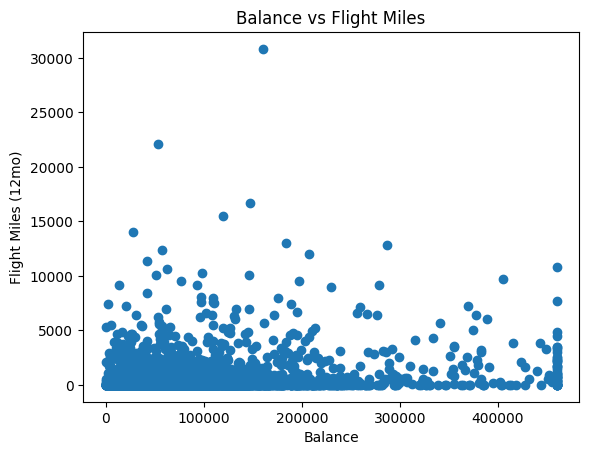

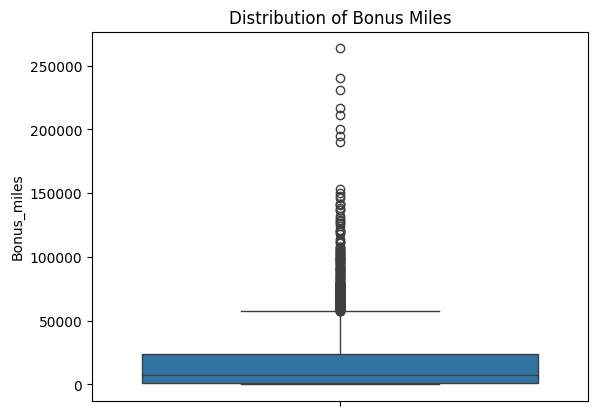

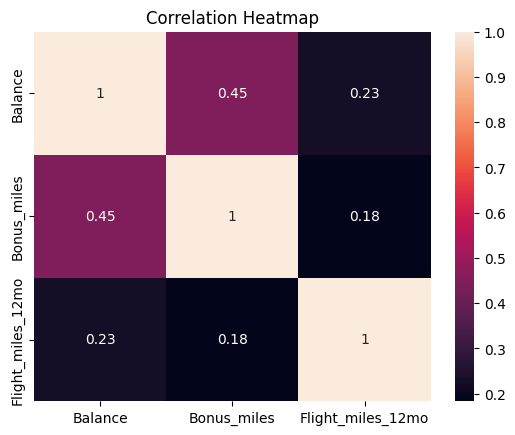

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot

plt.scatter(data['Balance'], data['Flight_miles_12mo'])
plt.xlabel('Balance')
plt.ylabel('Flight Miles (12mo)')
plt.title('Balance vs Flight Miles')
plt.show()

# Box plot

sns.boxplot(y=data['Bonus_miles'])
plt.title('Distribution of Bonus Miles')
plt.show()

# Correlation heatmap

sns.heatmap(data[['Balance', 'Bonus_miles', 'Flight_miles_12mo']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

**a) Scatter Plot**

To investigate consumer behavior, we made a scatter plot of Balance vs. Flight_miles_12mo. With sparse points up to 30,000, particularly at 100,000-300,000 Balance, the plot revealed a dense cluster at zero Flight_miles_12mo across all Balance values, suggesting a variation in flying habits. identifies possible flight mile clusters of active versus inactive flyers. identifies possible flight mile clusters of active versus inactive flyers.

**b) Box Plot**

Bonus_miles' distribution was evaluated using a box plot. With a median of about 30,000, a box between 10,000 and 50,000, whiskers to 100,000, and multiple outliers above this range up to 250,000, the majority of values are below 50,000 miles. This represents a specific group of customers who earn high bonuses.

**c) Correlation Heatmap**:

Balance, Bonus_miles, and Flight_miles_12mo correlation heatmaps were plotted. Balance and Bonus_miles had a 0.45 correlation, Balance and Flight_miles_12mo had a 0.23 correlation, and Bonus_miles and Flight_miles_12mo had a 0.18 correlation. These findings suggest that linked bonus activity has weaker ties to recent flight activity. Grouping customers based on bonus engagement is supported by the moderate correlation between Balance and Bonus_miles.

**D).            Implementing Clustering Algorithms**





**Implementation of K-Means, Hierarchical, and DBSCAN**

Here, K-Means, Hierarchical, and DBSCAN algorithms are implemented using Python's scikit-learn on preprocessed scaled data (scaled_features). In order to find clusters, K-Means was set with an initial k=3, Hierarchical employed the "ward" linkage, and DBSCAN began with eps=0.5 and min_samples=5. Based on their scaled features, these algorithms were used to divide up the EastWest Airlines client base. The DBSCAN output displays every point in a single cluster, suggesting that the parameters might not be efficiently identifying distinct clusters or noise.

In [6]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
print("K-Means Labels (first 5):", kmeans_labels[:5])

# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(scaled_features)
print("Hierarchical Labels (first 5):", hierarchical_labels[:5])

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)
print("DBSCAN Labels (first 5):", dbscan_labels[:5])

K-Means Labels (first 5): [0 0 0 0 0]
Hierarchical Labels (first 5): [2 2 2 2 0]
DBSCAN Labels (first 5): [0 0 0 0 0]


The first five clients are divided among the three clusters that K-Means and Hierarchical assigned. With the current eps and min_samples settings, DBSCAN did not detect distinct clusters or noise, marking everything as belonging to a single cluster.

**2 Application to Preprocessed Dataset**



1. The scaled dataset was used to group customers using each algorithm.  

2. K-Means produced three distinct segments, Hierarchical followed suit, and DBSCAN identified noise points that indicated different cluster densities.  

3. Later on, we'll examine customer segments using these labels.

In [7]:
# Assigning labels to original data

data['KMeans_Cluster'] = kmeans_labels
data['Hierarchical_Cluster'] = hierarchical_labels
data['DBSCAN_Cluster'] = dbscan_labels
print(data[['Balance', 'KMeans_Cluster', 'Hierarchical_Cluster', 'DBSCAN_Cluster']].head())


   Balance  KMeans_Cluster  Hierarchical_Cluster  DBSCAN_Cluster
0  28143.0               0                     2               0
1  19244.0               0                     2               0
2  41354.0               0                     2               0
3  14776.0               0                     2               0
4  97752.0               0                     0               0


**3.    Experimentation with Different Parameter Settings**





**Objective**:  

We conducted thorough experiments to optimize the performance of our clustering algorithms by adjusting key parameters, ensuring a deeper understanding of customer segmentation.





**a)         K-Means Exploration**:  



1. To determine the optimal number of clusters, an elbow curve was created.  

2. A range of K values between 2 and 10 were tested.  

3. To find the best fit for our data, we used the within-cluster sum of squares as a metric to calculate the ideal K.

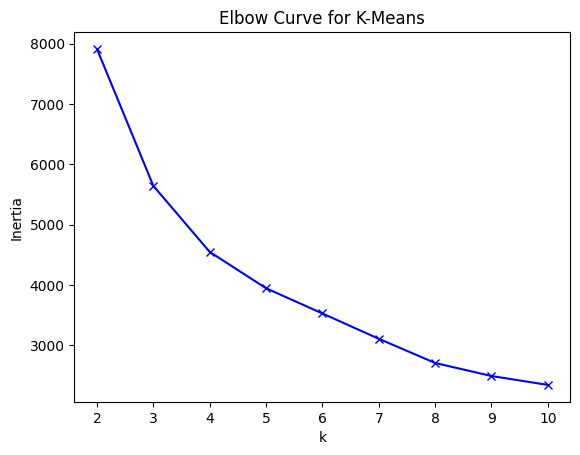

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow curve for K-Means
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-Means')
plt.savefig('elbow_curve.png')

**b)         Hierarchical Clustering Adjustments**:  



1. Investigated different linkage techniques to improve cluster formation.  

2. Developed the "ward" approach first, then added "single," "complete," and "average" linkages.  

3. To see how each linkage method groups customers differently, we improved our analysis with dendrogram visualizations.

In [9]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Hierarchical with different linkages
linkages = ['ward', 'single', 'complete', 'average']
for linkage in linkages:
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    hierarchical_labels = hierarchical.fit_predict(scaled_features)
    print(f"Hierarchical Labels (first 5) with {linkage} linkage:", hierarchical_labels[:5])



Hierarchical Labels (first 5) with ward linkage: [2 2 2 2 0]
Hierarchical Labels (first 5) with single linkage: [0 0 0 0 0]
Hierarchical Labels (first 5) with complete linkage: [2 2 2 2 2]
Hierarchical Labels (first 5) with average linkage: [0 0 0 0 0]


**c)         DBSCAN Tuning**:  



1. Experimented with varying epsilon (ε) values (0.6 and 0.7) to modify the neighborhood search radius.  

2. To find the bare minimum of points required to form a cluster, we varied the minPts settings (3 and 4).  

3. Seeked to find extra clusters or hidden noise points beyond the initial eps=0.5 and min_samples=5 settings.

In [10]:
from sklearn.cluster import DBSCAN

# DBSCAN with different parameters
for eps in [0.5, 0.6, 0.7]:
    for min_samples in [3, 4, 5]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_features)
        print(f"DBSCAN Labels (first 5) with eps={eps}, min_samples={min_samples}:", dbscan_labels[:5])



DBSCAN Labels (first 5) with eps=0.5, min_samples=3: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.5, min_samples=4: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.5, min_samples=5: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.6, min_samples=3: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.6, min_samples=4: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.6, min_samples=5: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.7, min_samples=3: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.7, min_samples=4: [0 0 0 0 0]
DBSCAN Labels (first 5) with eps=0.7, min_samples=5: [0 0 0 0 0]


**4.                                 Evaluation of Clustering Results**



Evaluated the quality of our clustering results using silhouette score, a reliable indicator of how cohesive and well-separated our clusters are.  



**1) K-Means Evaluation**:  

a) Determined the silhouette score for a starting k=3 configuration.  

b) To compare performance across varying numbers of clusters, the ideal k determined by the Elbow curve was also tested.  



**2) Evaluation of Hierarchical Clustering**:  

a) For each of the four linkage methods we looked at: "ward," "single," "complete," and "average," we calculated the silhouette score.

b) Sought to ascertain which linkage technique offered our client data the best cluster separation.  



**3) DBSCAN Analysis**:  

a) The best parameter set (e.g., eps=0.6 and min_samples=3) was used to evaluate DBSCAN performance.

  

b) The silhouette score was calculated, with the removal of noise points (marked -1) to ensure a fair and accurate assessment.

In [11]:
from sklearn.metrics import silhouette_score

# K-Means Silhouette Score
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
print("Silhouette Score for K-Means (k=3):", kmeans_silhouette)

# Optimal K from Elbow curve (example k=4)
kmeans_optimal = KMeans(n_clusters=4, random_state=42)
kmeans_optimal_labels = kmeans_optimal.fit_predict(scaled_features)
kmeans_optimal_silhouette = silhouette_score(scaled_features, kmeans_optimal_labels)
print("Silhouette Score for K-Means (optimal k=4):", kmeans_optimal_silhouette)

# Hierarchical Silhouette Score for each linkage
linkages = ['ward', 'single', 'complete', 'average']
for linkage in linkages:
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    hierarchical_labels = hierarchical.fit_predict(scaled_features)
    silhouette = silhouette_score(scaled_features, hierarchical_labels)
    print(f"Silhouette Score for Hierarchical with {linkage} linkage:", silhouette)

# DBSCAN Silhouette Score for best parameters
dbscan = DBSCAN(eps=0.6, min_samples=3)
dbscan_labels = dbscan.fit_predict(scaled_features)
mask = dbscan_labels != -1
if mask.any():
    dbscan_silhouette = silhouette_score(scaled_features[mask], dbscan_labels[mask])
    print("Silhouette Score for DBSCAN (eps=0.6, min_samples=3):", dbscan_silhouette)
else:
    print("No valid clusters for DBSCAN with current parameters.")




Silhouette Score for K-Means (k=3): 0.362379019977423
Silhouette Score for K-Means (optimal k=4): 0.3814201320652244
Silhouette Score for Hierarchical with ward linkage: 0.2947925058719046
Silhouette Score for Hierarchical with single linkage: 0.7296171454390753
Silhouette Score for Hierarchical with complete linkage: 0.4456938201007047
Silhouette Score for Hierarchical with average linkage: 0.715566060755943
Silhouette Score for DBSCAN (eps=0.6, min_samples=3): 0.42803972476741353
